# Distributed Shared-Nearest-Neighbor classifier

## Synthetic data generation (CURE dataset)

Dataset dimensions:(3,8100)



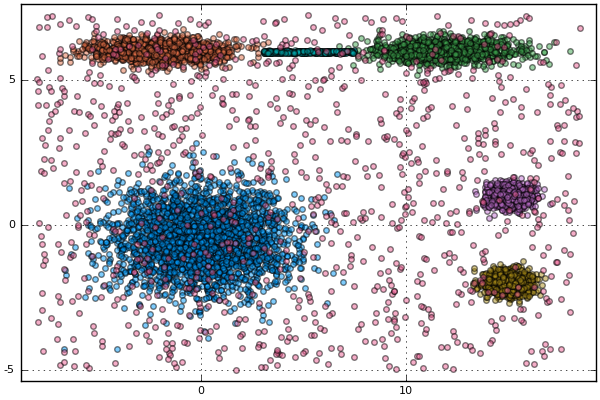

In [1]:
@everywhere push!(LOAD_PATH,"./src/")
using PyCall
@pyimport clustering_scores as cs #clustering_scores.py must be in the path.

using Plots
pyplot()

include("CureGenerator.jl")
DATA = generate(big_circle=2500, left_ellipse=1200, right_ellipse=1200, 
    upper_circle=900, lower_circle=1000, noisy_bridge=300, back_noise=1000);
println("Dataset dimensions:",size(DATA))
scatter(DATA[1,:],DATA[2,:],group = DATA[3,:], alpha=0.5, legend=false)

### Setting up the parallel environment

In [18]:
if length(workers()) > 1
    println("Removing previous workers...")
    rmprocs(workers())
end

nofworkers = 8
addprocs(nofworkers)

@everywhere using Distances
@everywhere using StatsBase
#include("parallelSNN.jl")
@everywhere include("WorkerSNN.jl");
@everywhere include("MasterSNN.jl");
using Clustering

sA = convert(SharedArray, DATA[1:2,:]);
N = size(DATA, 2)

partition = generate_partition(nofworkers, N); #N instances assigned to nofworkers cores.

Removing previous workers...


)) in module Main in module Main at /workspace/WorkerSNN.jl:5 overwritten at /workspace/WorkerSNN.jl:5 at /workspace/WorkerSNN.jl:5 overwritten.
 at /workspace/WorkerSNN.jl:5.
Float64, 2}) in module Main at /workspace/WorkerSNN.jl:5 overwritten at /workspace/WorkerSNN.jl:5.
, 2}, Array{Float64, 2}) in module Main at /workspace/WorkerSNN.jl:5 overwritten at /workspace/WorkerSNN.jl:5.
, Array{Float64, 2}) in module Main at /workspace/WorkerSNN.jl:27 overwritten at /workspace/WorkerSNN.jl:27.
Float64, 2}, Array{Float64, 2}) in module Main at /workspace/WorkerSNN.jl:47 overwritten at /workspace/WorkerSNN.jl:47.
}) in module Main at /workspace/WorkerSNN.jl:27 overwritten at /workspace/WorkerSNN.jl:27.
{Float64, 2}) in module Main overwritten.
1}, Main.#shared_nn_sim, Array{Float64, 2}, Int64, Array{Float64, 2}, Array{Float64, 2}) in module Main overwritten.
shared_nn_sim(Array{Float64, 2}, Int64, Array{Float64, 2}, Array{Float64, 2}) in module Main at /workspace/WorkerSNN.jl:47 overwritten 

### Performing the parameter tuning

In [ ]:
#worker_Eps, worker_MinPts, worker_k, pct_sample = 8, 8, 15, 0.3;
#@time master_work(results, sA, partition, worker_Eps, worker_MinPts, worker_k, pct_sample);

range_Eps = [20 30 40 50 60 70 80];
range_MinPts = [20 30 40 50 60 70 80];
range_K = [30 50 70 90 110];
pct_sample = 0.3;

max_dsnn_perf = -1;
max_dsnn_perf_tuple = []

real_labels = convert(Array{Int32,1}, DATA[3,:]);
results = Dict{String,Array{Int32,1}}()

for Eps=range_Eps
    for MinPts=range_MinPts
        for K=range_K            
            #@time
            # mark current state
            results["parameters"] = [Eps, MinPts, K];
            master_work(results, sA, partition, Eps, MinPts, K, pct_sample);
            
            if length(results["corepoints"]) > 0
                non_noisy_ixs = find(x -> x>0,results["assignments"]);
                noisy_ixs = find(x -> x<0,results["assignments"]);
                non_noisy_pts = results["sampledpoints"][non_noisy_ixs];
                noisy_pts = results["sampledpoints"][noisy_ixs];

                #println("Unique assignments:",length(unique(results["assignments"])) )
                #perf = randindex(real_labels[non_noisy_pts], results["assignments"][non_noisy_ixs])[1]
                scores = cs.clustering_scores(real_labels[results["sampledpoints"]], results["assignments"], false);
                
                if scores["VM"] > max_dsnn_perf
                    max_dsnn_perf = scores["VM"];
                    max_dsnn_perf_tuple = (Eps, MinPts, K);
                    println("[Current best VM] Eps:",Eps," MinPts:",MinPts," K:",K," ARI(sk):",
                    round(scores["ARI"],5)," VM(sk):",round(scores["VM"],5),
                    " #Gen.Samples:",length(results["sampledpoints"]) )
                end
            #else
            #    println("No results were found!")
            end
            #println()
        end
    end
end

_Running the_ __D-SNN__ _clustering with the selected parameter values:_

In [54]:
#Eps, MinPts, K = max_dsnn_perf_tuple[1], max_dsnn_perf_tuple[2], max_dsnn_perf_tuple[3];
Eps, MinPts, K = 60, 50, 90;

pct_sample = 0.1;
real_labels = convert(Array{Int32,1}, DATA[3,:]);

results = Dict{String,Array{Int32,1}}()
@time master_work(results, sA, partition, Eps, MinPts, K, pct_sample,similarity="euclidean");
#@time master_work(results, sA, partition, 25, 50, 50, 0.3);

non_noisy_ixs = find(x -> x>0,results["assignments"]);
noisy_ixs = find(x -> x<0,results["assignments"]);
non_noisy_pts = results["sampledpoints"][non_noisy_ixs];
noisy_pts = results["sampledpoints"][noisy_ixs];

println("\n[Parameters] Eps:",Eps," MinPts:", MinPts," K:", K)
scores = cs.clustering_scores(real_labels[non_noisy_pts], results["assignments"][non_noisy_ixs], false);
println("ARI:",scores["ARI"]," VM:",scores["VM"])

println("\nsampled points:",size(results["sampledpoints"],1)," assignments:",size(results["assignments"],1))
println("#noisy pts:",length(noisy_pts)," #labeled pts:",length(non_noisy_pts)," #Clusters:",length(results["labels"]) )

  0.373090 seconds (21.98 k allocations: 50.378 MB, 1.75% gc time)

[Parameters] Eps:60 MinPts:50 K:90
ARI:0.6964516006334378 VM:0.8224354149627097

sampled points:629 assignments:629
#noisy pts:10 #labeled pts:619 #Clusters:7


_Contrasting the Noisy points (+) and Non-Noisy (o) points identified in the sample generated by the D-SNN method:_


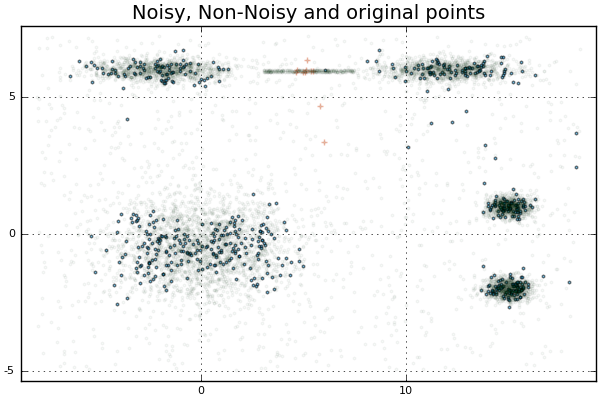

In [55]:
#non_noise_pts = results["sampledpoints"];
scatter(DATA[1,non_noisy_pts],DATA[2,non_noisy_pts], marker=(0.5,:h,2), alpha=0.3, legend=false)
scatter!(DATA[1,noisy_pts],DATA[2,noisy_pts], marker=(0.5,:+,5), alpha=0.5, legend=false)
scatter!(DATA[1,:],DATA[2,:], marker=(0.04,:h,2), legend=false)
title!("Noisy, Non-Noisy and original points")
#scatter(DATA[1,results["sampledpoints"]],DATA[2,results["sampledpoints"]], alpha=0.5)

_Plotting the complete dataset (blurry) and highlighting the_ __core-points__ _obtained over the D-SNN method:_


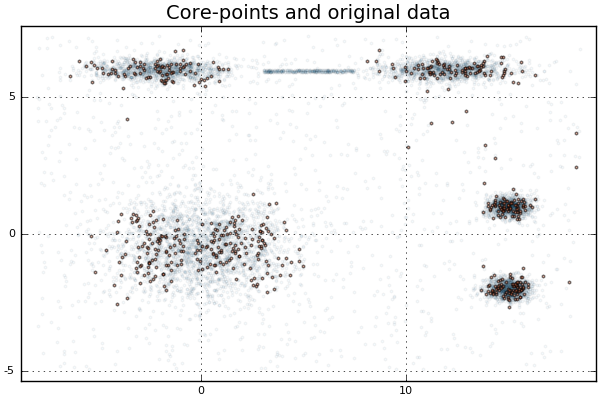

In [56]:
scatter(DATA[1,:],DATA[2,:], marker=(0.04,:h,2), legend=false)
scatter!(DATA[1,results["sampledpoints"][results["corepoints"]]],DATA[2,results["sampledpoints"][results["corepoints"]]], marker=(0.5,:h,2), legend=false)
title!("Core-points and original data")

## Experiments performed over the data sampled by the D-SNN algorithm

_After taking the data sampled by the D-SNN method, a new centralized SNN-clustering is performed. Its parameters are tuned as follows:_

In [57]:
master_Eps, master_MinPts, master_k = 10,10, 30;

range_Eps = [5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80];
range_MinPts = [5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80];
range_K = [10 20 30 40 50 70 90 110];
max_perf = -1;
max_perf_tuple = []

for Eps=range_Eps
    for MinPts=range_MinPts
        for K=range_K 
            
            cluster_assignment, core_points, cluster_labels = snn_clustering(DATA[:,results["sampledpoints"]], Eps, MinPts, K, similarity="euclidean");
            
            non_noisy_ixs = find(x -> x>0, cluster_assignment);
            noisy_ixs = find(x -> x<0, cluster_assignment);
            non_noisy_pts = results["sampledpoints"][non_noisy_ixs];
            noisy_pts = results["sampledpoints"][noisy_ixs];

            if length(core_points) > 0
                scores = cs.clustering_scores(convert(Array{Int32,1}, DATA[3, results["sampledpoints"]]), cluster_assignment, false);
                if scores["VM"] > max_perf
                        max_perf = scores["VM"];
                        max_perf_tuple = (Eps, MinPts, K);
                        println("[Current best ARI] Eps:",Eps," MinPts:",MinPts," K:",K," ARI:",scores["ARI"]," VM:",scores["VM"])
                end
            end
        end
    end
end

[Current best ARI] Eps:5 MinPts:5 K:10 ARI:0.14764816210156068 VM:0.5931374594116882
[Current best ARI] Eps:5 MinPts:5 K:20 ARI:0.5211046192999147 VM:0.698736126685061
[Current best ARI] Eps:5 MinPts:5 K:30 ARI:0.5510232185119304 VM:0.7225069020976235
[Current best ARI] Eps:5 MinPts:5 K:40 ARI:0.75109763352537 VM:0.82084968010722
[Current best ARI] Eps:5 MinPts:70 K:40 ARI:0.7523171349918966 VM:0.8274992305471499
[Current best ARI] Eps:5 MinPts:75 K:30 ARI:0.794312564209019 VM:0.843868916522356
[Current best ARI] Eps:10 MinPts:75 K:50 ARI:0.9066022752372259 VM:0.8772601019027746
[Current best ARI] Eps:40 MinPts:5 K:90 ARI:0.9065110130504367 VM:0.8814950015882819
[Current best ARI] Eps:50 MinPts:80 K:70 ARI:0.8979240703793961 VM:0.8887790182250115


_Running the_ __SNN__ _clustering with the selected parameter values:_

In [29]:
cluster_assignment, core_points, cluster_labels = snn_clustering(DATA[:,results["sampledpoints"]], max_perf_tuple[1], max_perf_tuple[2], max_perf_tuple[3]);

println("#noisy pts:",length(find(x -> x<0, cluster_assignment))," #Unlabeled pts:",length(find(x -> x==0, cluster_assignment))," #labeled pts:",length(find(x -> x>0, cluster_assignment)) )

non_noisy_ixs = find(x -> x>0, cluster_assignment);
noisy_ixs = find(x -> x<0, cluster_assignment);
non_noisy_pts = results["sampledpoints"][non_noisy_ixs];
noisy_pts = results["sampledpoints"][noisy_ixs];

perf = randindex(convert(Array{Int32,1}, DATA[3,results["sampledpoints"]]), cluster_assignment)[1];
println("ARI:",perf)

#noisy pts:283 #Unlabeled pts:0 #labeled pts:481
ARI:0.8446844673261736


_Plotting the data sampled by the D-SNN method in terms of Noisy (+) and Non-Noisy (o) points:_


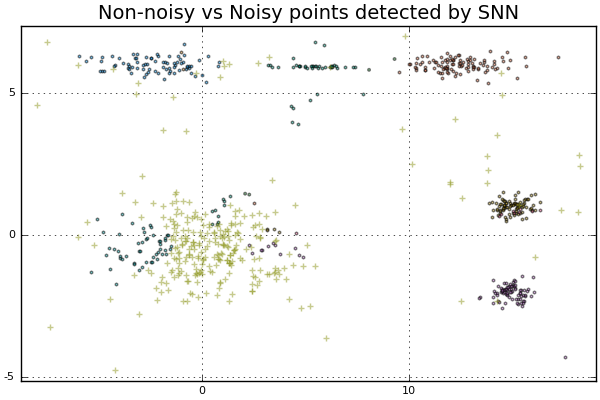

In [30]:
scatter(DATA[1,non_noisy_pts],DATA[2,non_noisy_pts], group=cluster_assignment[non_noisy_ixs], marker=(0.5,:h,2), alpha=0.3, legend=false)
scatter!(DATA[1,noisy_pts],DATA[2,noisy_pts], marker=(0.5,:+,5), alpha=0.5, legend=false)
title!("Non-noisy vs Noisy points detected by SNN")

_Plotting the complete dataset (blurry) and highlighting the core-points obtained over the sampled data:_


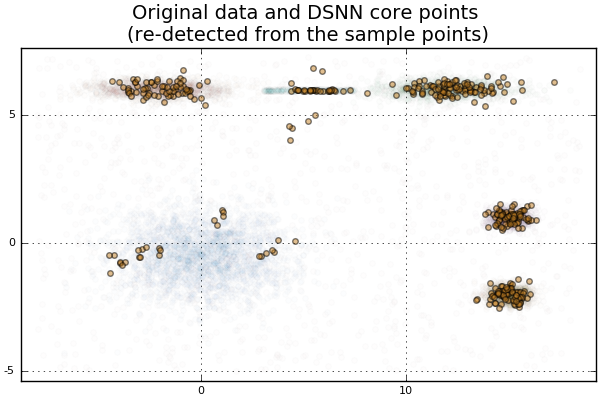

In [31]:
scatter(DATA[1,:],DATA[2,:],group = DATA[3,:], alpha=0.01, legend=false)
scatter!(DATA[1,results["sampledpoints"][core_points]],DATA[2,results["sampledpoints"][core_points]], alpha=0.5, legend=false)
title!("Original data and DSNN core points \n(re-detected from the sample points)")

In [ ]:
unique(results["labels"])

In [ ]:
#direct_sample!([rng], a, wv, x)
using StatsBase

## Centralized experiments using all the data

In [ ]:
range_Eps = [5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80];
range_MinPts = [5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80];
range_K = [10 20 30 40 50 70 90 110];
pct_sample = 0.3;

max_perf = -1;
max_perf_tuple = []

for Eps=range_Eps
    for MinPts=range_MinPts
        for K=range_K 
            
            cluster_assignment, core_points, cluster_labels = snn_clustering(DATA, Eps, MinPts, K);
            
            non_noisy_ixs = find(x -> x>0, cluster_assignment);
            noisy_ixs = find(x -> x<0, cluster_assignment);
            non_noisy_pts = non_noisy_ixs;
            noisy_pts = noisy_ixs;

            if length(core_points) > 0
                scores = cs.clustering_scores(convert(Array{Int32,1}, DATA[3, :]), cluster_assignment, false);
                if scores["VM"] > max_perf
                        max_perf = scores["VM"];
                        max_perf_tuple = (Eps, MinPts, K);
                        println("[Current best ARI] Eps:",Eps," MinPts:",MinPts," K:",K," ARI:",scores["ARI"]," VM:",scores["VM"])
                end
            end
        end
    end
end

In [ ]:
@pyimport SNNClustering as SNN
Eps, MinPts, K = 50, 75, 90;

N = size(DATA,2)
S = Array{Float64}(N,N);
euclidean_sim(DATA[1:2,:], S);

knn_info = SNN.compute_knn(S, K);  # sparsify the similarity matrix
snn_sim  = SNN.compute_snn(knn_info);  # obtains the snn similarity matrix

CP, NCP, NP, CL = SNN.snn_clustering(snn_sim, Eps, MinPts);
scores_py = cs.clustering_scores(convert(Array{Int32,1}, DATA[3, :]), CL, false);

In [ ]:
@time begin
cluster_assignment, core_points, cluster_labels = snn_clustering(DATA[1:2,:], Eps, MinPts, K, similarity="euclidean");
end
scores_jl = cs.clustering_scores(convert(Array{Int32,1}, DATA[3, :]), cluster_assignment, false);

In [ ]:
function dict2str(D::Dict{Any,Any})
    out = "";
    for i in keys(D)
        out = out*i*" => "*string(round(D[i],4))*"\r\n"
    end
    return out
end

In [ ]:
println(dict2str(scores_py),"\r\n",dict2str(scores_jl))

In [ ]:
scatter(DATA[1,:],DATA[2,:], alpha=0.01, legend=false)
scatter!(DATA[1,(CP+1)],DATA[2,(CP+1)], alpha=0.5, legend=false) 
title!("Original data and DSNN core points")

In [ ]:
scatter(DATA[1,:],DATA[2,:], alpha=0.01, legend=false)
scatter!(DATA[1,core_points],DATA[2,core_points], alpha=0.5, legend=false) 
title!("Original data and DSNN core points")